# Score Functions

We're going to need some basic knowledge and terminology established first,
otherwise, the terminology may become overwhelming,
especially for those who are not well-versed in probabilistic modelling.
As such, we're going to start with a bunch of definitions.
Don't skip these, they're important!

## Definitions

What's a score function?
The score function is defined as follows:

> The score function is
> the gradient of the log of the probability density function 
> of a probability distribution
> with respect to the distribution's support.

There's a lot to unpack in there, 
so let's dissect the anatomy of this definition bit by bit.

### Probability Distributions

Probability distributions are super cool objects in stats[^bayes].
Distributions can be **configured** through their parameters;
for example, by setting the values $\mu$ and $\sigma$ of a Gaussian respectively.
We can use probability distributions to generate data, 
and we can use them to evaluate the likelihood of observed data.
The latter point is done by using a probability distribution's
**probability density function**[^discrete].

[^bayes]: I've explored the anatomy of a probability distribution
in my essay on [Bayesian and computational statistics][bayes],
and would recommend looking at it for a refresher.

[^discrete]: Or the probability mass function, for discrete distributions,
but we're going to stick with continuous distributions for this essay.

[bayes]: https://ericmjl.github.io/essays-on-data-science/machine-learning/computational-bayesian-stats/

### $P(x)$ a.k.a. Probability Density Function

A distribution's probability density function (PDF)
describes the propensity of a probability distribution
to generate draws of a particular value.
As mentioned above, we primarily use the PDF to
_evaluate the likelihood of the observing data, given the distribution's configuration_.
If you need an anchoring example, 
think of the venerable Gaussian probability density function in @fig-likelihood.

In [1]:
#| echo: false 
#| output: false
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
#| echo: false 
#| output: false
import os 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

from jax.scipy.stats import norm
import jax.numpy as np
from jax import grad, vmap
import matplotlib.pyplot as plt
import seaborn as sns


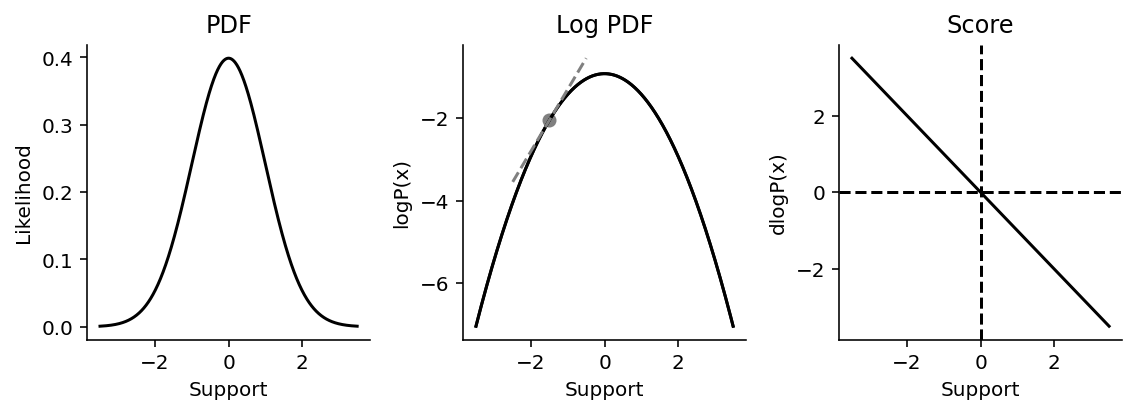

In [3]:
#| echo: false
#| label: fig-likelihood
#| fig-cap: "$P(x)$ (likelihood, PDF), $log P(x)$ (log likelihood, logp), and $dlogP(x)$ (score) of a Gaussian."
#| code-fold: true

from jax.scipy.stats import norm
import jax.numpy as np
from jax import grad, vmap
import matplotlib.pyplot as plt
import seaborn as sns

 
fig, axes = plt.subplots(figsize=(8, 3), nrows=1, ncols=3, sharex=True)

plt.sca(axes[0])
x = np.linspace(-3.5, 3.5, 1000)
y = norm.pdf(x)
plt.plot(x, y, color="black")
plt.xlabel("Support")
plt.ylabel("Likelihood")
plt.title("PDF")
sns.despine()

y = norm.logpdf(x)
plt.sca(axes[1])
plt.plot(x, y, color="black")
plt.xlabel("Support")
plt.ylabel("logP(x)")
plt.title("Log PDF")

# Tangent Line
def line(x):
    return grad(norm.logpdf)(x_pt) * (x - x_pt) + y_pt
x_pt = -1.5
y_pt = norm.logpdf(x_pt)
xrange = np.linspace(x_pt - 1, x_pt + 1, 10)
plt.plot(x, y, color="black")
plt.scatter(x_pt, y_pt, color="gray")
plt.plot(xrange, vmap(line)(xrange), color="gray", ls="--")


plt.sca(axes[2])
plt.plot(x, vmap(grad(norm.logpdf))(x), color="black")
plt.axhline(y=0, ls="--", color="black")
plt.axvline(x=0, ls="--", color="black")
plt.xlabel("Support")
plt.ylabel("dlogP(x)")
plt.title("Score")

sns.despine()
plt.tight_layout()

Every distribution has a **support**,
which is the range of values for which the probability distribution is defined.
The Gaussian has support in the range $(-\infty, \infty)$,
while positive-only distributions (such as the Exponential)
have support in the range $(0, \infty)$.

### $log P(x)$ a.k.a. Log PDF

Because the PDF is nothing more than a math function, we can take its logarithm!
In computational statistics, taking the log is usually done for pragmatic purposes,
as we usually end up with underflow issues otherwise.
For the standard Gaussian above, its log PDF looks like what we see in @fig-likelihood.

We often call the log PDF **logp** for short,
and in the probabilistic programming language PyMC,
`logp` is the name of the class method use for calculating 
the log likelihood of data under the distribution.

### $dlogP(x)$ a.k.a. Score Function

Finally, we get to the **score**.
As it turns out, because the logp function is differentiable,
we can take its derivative easily (using JAX, for example).
The derivative of the logp function is called the **score function**.
The score of a distribution is the gradient of the logp function w.r.t. the support.
You can visualize what it is like in @fig-likelihood.

In JAX, obtaining the score function is relatively easy.
We simply need to use JAX's `grad` function to obtain the transformed logp function.

In [4]:
from jax import grad 
gaussian_score = grad(norm.logpdf)


Since we're using a Gaussian as our anchoring example,
let's examine some properties of the score function.
From visual inspection above,
we know that at the top of the Gaussian,
the gradient should be zero,
and can verify as much.

In [5]:
gaussian_score(0.0)

DeviceArray(-0., dtype=float32, weak_type=True)

At the tails, the gradient should be of higher magnitude
than at the mean.

In [6]:
gaussian_score(-3.0), gaussian_score(3.0)

(DeviceArray(3., dtype=float32, weak_type=True),
 DeviceArray(-3., dtype=float32, weak_type=True))

## Estimating the score function

In 2005, Aapo Hyvärinen published a paper in the Journal of Machine Learning Research
that details how to _estimate_ the score function
in the absence of knowledge of 
the true data generating distribution [@JMLR:v6:hyvarinen05a].
When I first heard of the idea, I thought it was crazy --
crazy cool that we could even do this!

[hyvarinen]: https://jmlr.csail.mit.edu/papers/volume6/hyvarinen05a/old.pdf

So how do we use data to estimate the score of that data 
without knowing the true probability density?
One key equation in the paper is equation #4.
This equation details how we can use an arbitrary function, $\psi(x, \theta)$,
to approximate the score function,
and the loss function needed to train the parameters of the function $\theta$
to approximate the score function.
I've replicated the equation below,
alongside a bullet-point explanation of what each of the terms are:

$$J(\theta) = \frac{1}{T} \sum_{t=1}^{T} \sum_{i=1}^{n} [\delta_i \psi_i(x(t); \theta) + \frac{1}{2} \psi_i(x(t); \theta)^2 ] + \text{const}$$

Here:

- $J(\theta)$ is the loss function that we wish to minimize w.r.t. the parameters $\theta$
- $\theta$ are the parameters of the function $\psi_i$
- $\psi_i(x(t); \theta)$ is the multidimensional score function estimator for $x$. $\psi_i$ has parameters $\theta$. 
  - The subscript $i$ is a dimensional indexer. If $x$ is 2-dimensional, then $i=2$.
- $x(t)$ are the i.i.d. samples from the unknown data-generating distribution.
- $\delta_i$ refers to the partial derivative w.r.t. dimension $i$ in $x$.
- $\text{const}$ is a constant term that effectively can be ignored.


Let's explore the idea in a bit more detail.
What we're ultimately going to do here 
is use a simple feed-forward neural network
as the score function estimator $\psi(x(t), \theta)$.
Let's start first by generating the kind of data that's needed
for score function estimation to work.

In [7]:
#| code-fold: true

from jax import random

key = random.PRNGKey(44)

true_mu = 3.0
true_sigma = 1.0
data = random.normal(key, shape=(1000, 1)) * true_sigma + true_mu
data[0:5]  # showing just the first 10 samples drawn


DeviceArray([[0.8219464],
             [3.8602278],
             [1.4089172],
             [3.4423368],
             [3.2420166]], dtype=float32)

Before we go on, we should also verify that the $\mu$ and $\sigma$ of the data 
are as close to the ground truth as possible.

In [8]:
data.mean(), data.std()

(DeviceArray(2.9986675, dtype=float32), DeviceArray(1.0197434, dtype=float32))

### Baseline: evaluate score under known PDF

Now, let's try to evaluate the score function directly.
The purpose here is to establish a baseline model to compare against
and to set up the patterns for training a neural network model.
In anticipation of writing neural network models later,
I have opted to write our models, neural network or otherwise,
in the style of Equinox [@kidger2021equinox],
which provides a way to associate model parameters with a callable object directly
while maintaining compatibility with the rest of the JAX ecosystem.

In [9]:
from score_models.models.gaussian import GaussianModel
from inspect import getsource

print(getsource(GaussianModel))

class GaussianModel(eqx.Module):
    """Univariate Gaussian score function."""

    mu: np.array = np.array(0.0)
    log_sigma: np.array = np.array(0.0)

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            as the model is intended to be vmapped over batches of data.
        :returns: Score of a Gaussian conditioned on a `mu` and `log_sigma`.
        """
        gaussian_score_func = jacfwd(norm.logpdf)
        return gaussian_score_func(x, loc=self.mu, scale=np.exp(self.log_sigma))



Above, instead of `grad`, we are using `jacfwd`,
which gives us the Jacobian of `norm.logpdf`.
The Jacobian is a generalization of the first derivative, extended to matrix inputs.
To test that we have the implementation done correct,
let's ensure that we can evaluate the `GaussianModel` score function
at a few special points.

In [10]:
gaussian_model = GaussianModel()
(
    gaussian_model(-3.0),
    gaussian_model(0.0),
    gaussian_model(3.0),
)

(DeviceArray(3., dtype=float32, weak_type=True),
 DeviceArray(-0., dtype=float32, weak_type=True),
 DeviceArray(-3., dtype=float32, weak_type=True))

Let's also ensure that we can evalute the score function at each data point.
We will use the `vmap` function to explicitly map `score_func` across all data points.

In [11]:
data_score = vmap(gaussian_model)(data).squeeze()
data_score[0:5]

DeviceArray([-0.8219464, -3.8602278, -1.4089172, -3.4423368, -3.2420166],            dtype=float32)

### Train baseline score function model

Here, we've instantiated the Gaussian with default parameters ($\mu=0$ and $\sigma=1$),
but those aren't the true configuration of the underlying data-generating process.
Hence, our score calculated scores are going to be way off,
as is visible in @fig-score.

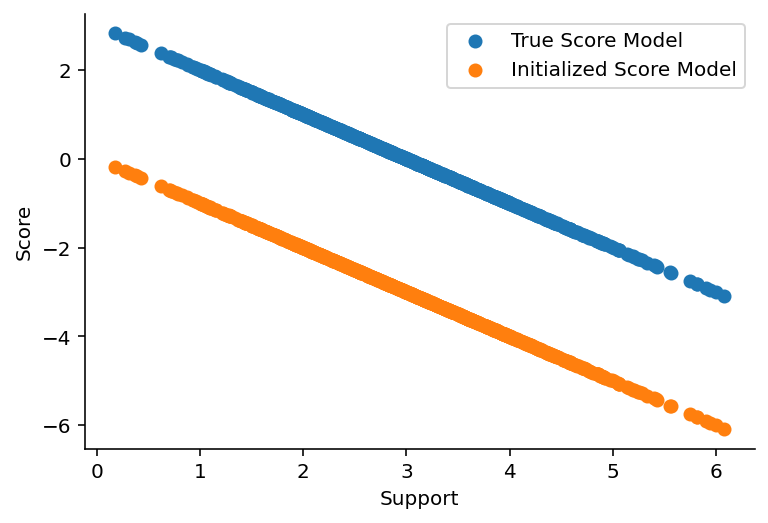

In [12]:
#| code-fold: true
#| echo: false
#| label: fig-score
#| fig-cap: "Comparison of score function evaluated under the true vs. incorrect data-generating distribution parameters"

import numpy as onp 

true_model = GaussianModel(mu=true_mu, log_sigma=np.log(true_sigma))
true_model_scores = vmap(true_model)(data)
plt.scatter(data.squeeze(), true_model_scores.squeeze(), label="True Score Model")
plt.scatter(data.squeeze(), data_score.squeeze(), label="Initialized Score Model")
plt.xlabel("Support")
plt.ylabel("Score")
plt.legend()
sns.despine()

Since the model is wrong, we're going to see if we can make it right.
One generic way to train models is to use gradient descent;
that's what we'll use here.
For us, we'll be using optax 
alongside a fitting routine that I have implemented before.

Finally, we've reached the point where we can implement the score function loss in JAX!
Let's see it below, with the earlier equation from above copied down here for convenience.

$$J(\theta) = \frac{1}{T} \sum_{t=1}^{T} \sum_{i=1}^{n} [\delta_i \psi_i(x(t); \theta) + \frac{1}{2} \psi_i(x(t); \theta)^2 ] + \text{const}$$

We can now train the model.

In [13]:
from score_models.training import fit
from score_models.losses import score_matching_loss
import optax

optimizer = optax.adam(learning_rate=5e-3)
updated_model, loss_history = fit(
    gaussian_model, 
    data, 
    score_matching_loss, 
    optimizer, 
    steps=2_000, 
    progress_bar=False
)


Let's take a peek at the loss curve to make sure our model is fitting.

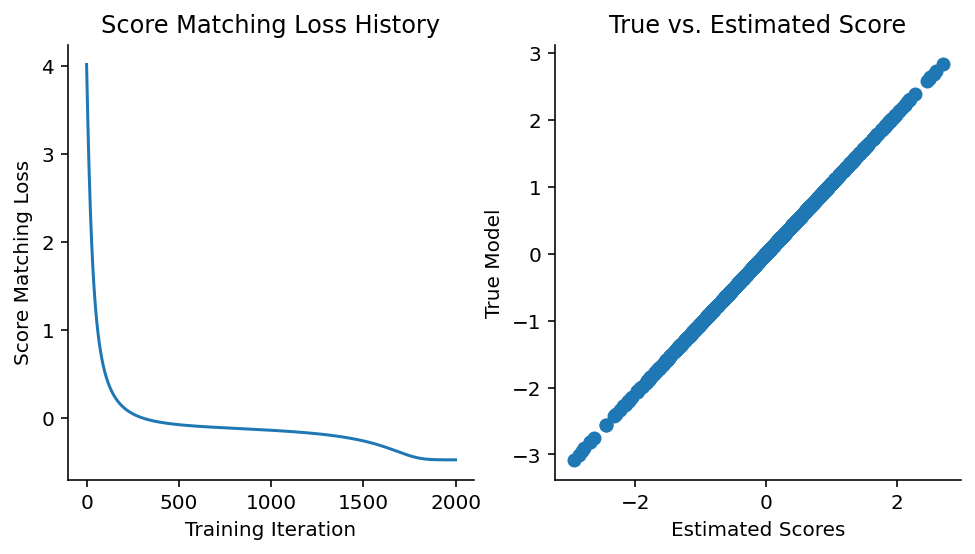

In [14]:
#| code-fold: true
#| label: fig-gaussian-model-loss-history
#| fig-cap: "Loss curve for Gaussian score model."

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)


plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Score Matching Loss")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(data)
plt.scatter(updated_model_scores.squeeze(), true_model_scores.squeeze())
plt.xlabel("Estimated Scores")
plt.ylabel("True Model")
plt.title("True vs. Estimated Score")
sns.despine()

It's reassuring to see the loss decrease and the estimated scores match up with the predicted scores.

And here are the mean and standard deviation of the data vs. the model estimates.

In [15]:
np.mean(data), np.std(data), updated_model.mu, np.exp(updated_model.log_sigma)

(DeviceArray(2.9986675, dtype=float32),
 DeviceArray(1.0197434, dtype=float32),
 DeviceArray(2.9963465, dtype=float32),
 DeviceArray(1.0235364, dtype=float32))

## Approximate Score Functions

Now, the entire premise of Hyvärinen's paper is that 
we need not know the original form of the PDF
and we'd still be able to _estimate_ the score at each data point.
Since the score function is smooth and differentiable,
we can reach for the venerable neural network,
a.k.a. the universal function approximator,
as our estimation model for the score of our data.

### Neural Network Approximator

Here, we will set up a single feed-forward neural network model
with 1 hidden layer of width 1024 and a ReLU activation function.
Here is the source of my wrapper implementation around Equinox's MLP.

In [16]:
from score_models.models.feedforward import FeedForwardModel1D

print(getsource(FeedForwardModel1D))

class FeedForwardModel1D(eqx.Module):
    """Feed-forward NN model."""

    mlp: eqx.Module

    def __init__(
        self,
        in_size=1,
        out_size=1,
        width_size=4096,
        depth=1,
        activation=nn.relu,
        key=random.PRNGKey(45),
    ):
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=key,
        )

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            as the model is intended to be vmapped over batches of data.
        :returns: Estimated score of a Gaussian.
        """
        return self.mlp(x)



### Training Objective/Loss Function

For our loss function, I know from previous experience with these models
that we could get weights that explode to really large magnitudes.
To control this, 
I have chained in an L2 regularization on the weights on the loss function.

In [17]:
from jax import nn 
from score_models import losses

regularized_loss = losses.chain(
    losses.l2_norm, 
    losses.score_matching_loss,
)

Now, we can train the model.

In [18]:
ffmodel = FeedForwardModel1D(depth=1, width_size=1024, activation=nn.relu)
optimizer = optax.chain(
    optax.clip(0.01),
    optax.sgd(learning_rate=5e-3),
)
updated_model, history = fit(
    ffmodel,
    data,
    regularized_loss,
    optimizer,
    steps=2_000,
    progress_bar=False,
)

### Approximator Performance

Now, let's visualize the training loss and how the model compares to ground truth.

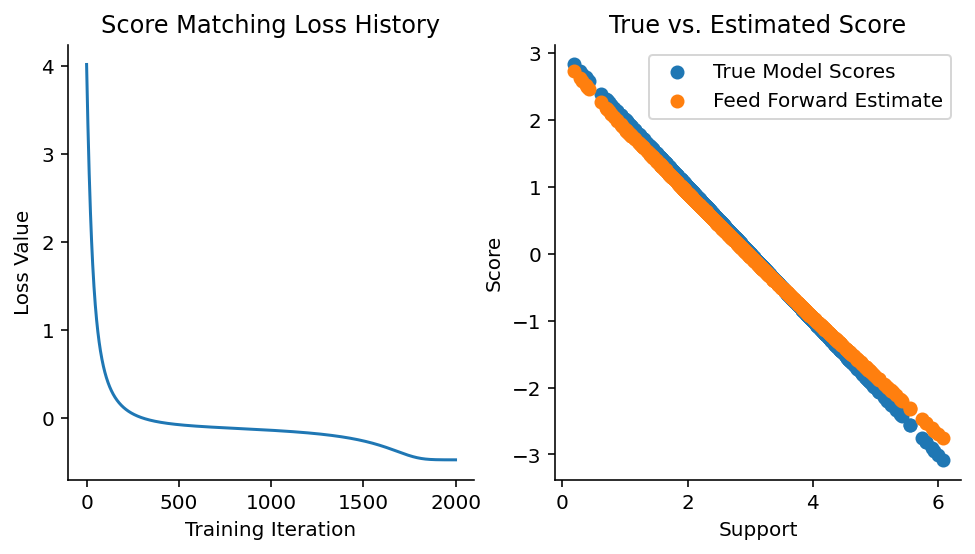

In [19]:
#| label: fig-nn-model-loss-and-perf
#| fig-cap: "Loss curve and performance plot for Neural Network score model."
#| code-fold: true

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Loss Value")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(data).squeeze()
plt.scatter(data.squeeze(), true_model_scores, label="True Model Scores")
plt.scatter(data.squeeze(), updated_model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend()
sns.despine()

This isn't bad at all!
We're off by a bit, 
but keep in mind that we only had data on hand
and didn't know what the exact data-generating density is.
We should expect to be a bit off.

## Mixture Distributions

While data drawn from a Gaussian is nice and ideal,
you won't really be able to tell if your data came from a Gaussian[^downey].
In addition, most data would have the characteristics
of being generated from a mixture distribution.
In other words, mixture distributions are what our data will look the most like.
Let's make sure our approximate score function 
can approximate the mixture distribution scores as accurately as possible,
at least in 1 dimension.

[^downey]: Allen Downey has an [excellent blog post][downey] on this matter.

[downey]: http://allendowney.blogspot.com/2013/08/are-my-data-normal.html

### Mixture Gaussian Model

We have a `MixtureGaussian` model 
that implements the score of a mixture Gaussian distribution.
Its source is below:

In [20]:
from score_models.models.gaussian import MixtureGaussian

print(getsource(MixtureGaussian))

class MixtureGaussian(eqx.Module):
    """Mixture Gaussian score function."""

    mus: np.array
    log_sigmas: np.array
    ws: np.array

    def __init__(self, mus, log_sigmas, ws):
        self.mus = mus
        self.log_sigmas = log_sigmas
        self.ws = ws

        # Check that mus, log_sigmas, and ws are of the same length.
        lengths = set(map(len, [mus, log_sigmas, ws]))
        if len(lengths) != 1:
            raise ValueError(
                "`mus`, `log_sigmas` and `ws` must all be of the same length!"
            )

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            as the model is intended to be vmapped over batches of data.
        :returns: Score of a Gaussian conditioned on a `mu` and `log_sigma`.
        """
        return partial(
            dmixture_logpdf,
            mus=self.mus,
            sigmas=np.exp(self.log_sigmas),
            ws=self.ws,
        )(x)



### Mixture Gaussian Score Function 

Let's use the model to plot Gaussian data and the true Gaussian mixture score.

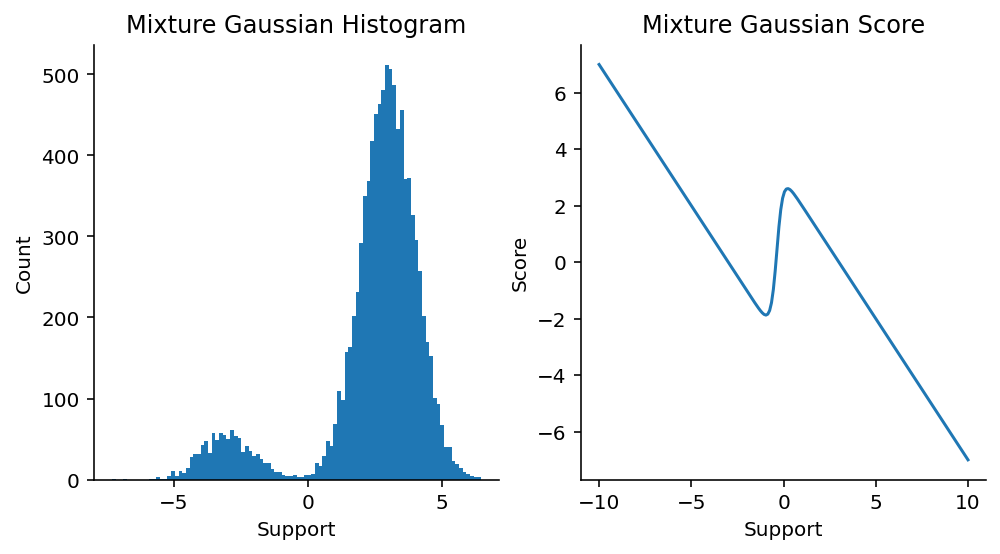

In [21]:
#| label: fig-two-comp-mixture-gaussian
#| fig-cap: A two-component mixture Gaussian and its score function
#| code-fold: true

import seaborn as sns 
import numpy as onp 

x = np.linspace(-10, 10, 200)
mus = np.array([-3, 3])
sigmas = np.array([1, 1])
ws = np.array([0.1, 0.9])

mgmodel = MixtureGaussian(mus, np.log(sigmas), ws)
mixture_logpdf_grads = vmap(mgmodel)(x)


fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
k1, k2 = random.split(random.PRNGKey(55))
draws = 1000
mix1 = random.normal(k1, shape=(1000,)) * 1 - 3
mix2 = random.normal(k2, shape=(9000,)) * 1 + 3
data = np.concatenate([mix1, mix2]).reshape(-1, 1)
plt.hist(onp.array(data), bins=100)
plt.title("Mixture Gaussian Histogram")
plt.xlabel("Support")
plt.ylabel("Count")
sns.despine()

plt.sca(axes[1])
plt.plot(x, mixture_logpdf_grads)
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Mixture Gaussian Score")
sns.despine()


### Train neural network approximator

Then, we're going to use the feed forward neural network model from before
to try to fit the mixture Gaussian data above.

In [22]:
optimizer = optax.chain(
    optax.clip(0.01),
    optax.sgd(learning_rate=5e-3),
)
updated_model, history = fit(
    ffmodel,
    data,
    losses.score_matching_loss,
    optimizer,
    steps=1_000,
    progress_bar=False,
)

Let's see how the loss looks like:

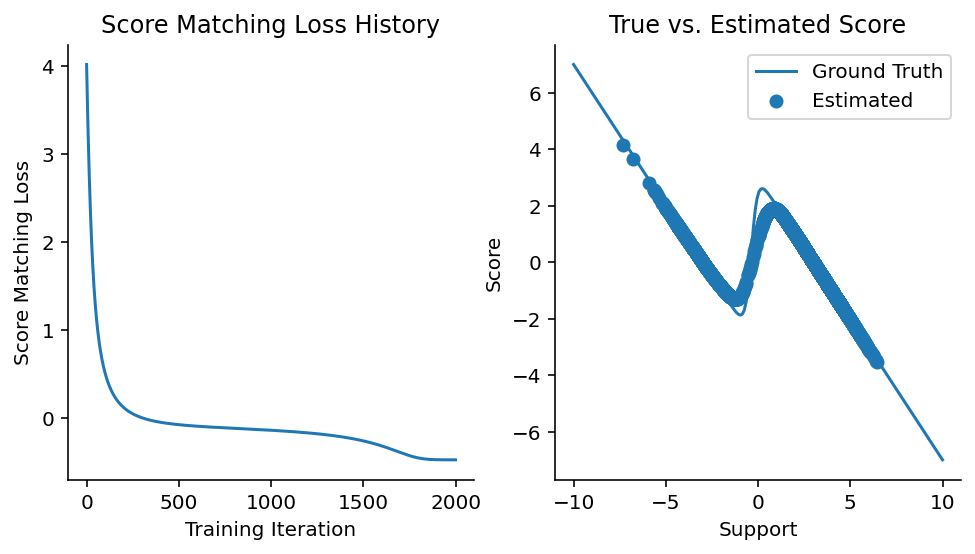

In [23]:
#| label: fig-nn-model-mixture-loss-history
#| fig-cap: "Loss curve for neural network score model approximator for 2-component mixture Gaussian."
#| code-fold: true

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Score Matching Loss")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
mixture_est_scores = vmap(updated_model)(data)
plt.plot(x, mixture_logpdf_grads, label="Ground Truth")
plt.scatter(data, mixture_est_scores, label="Estimated")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend()
sns.despine()

Not bad! 
It's clear to me that we can approxiate 
the score function of a 2-component mixture Gaussian here.

## 3-Component Mixture

We're now going to see whether we can approximate a 3-component mixture.
This will be the example that rounds out this chapter.
Firstly, let's see draws from a 3-component mixture model
and the score function of this mixture distribution.

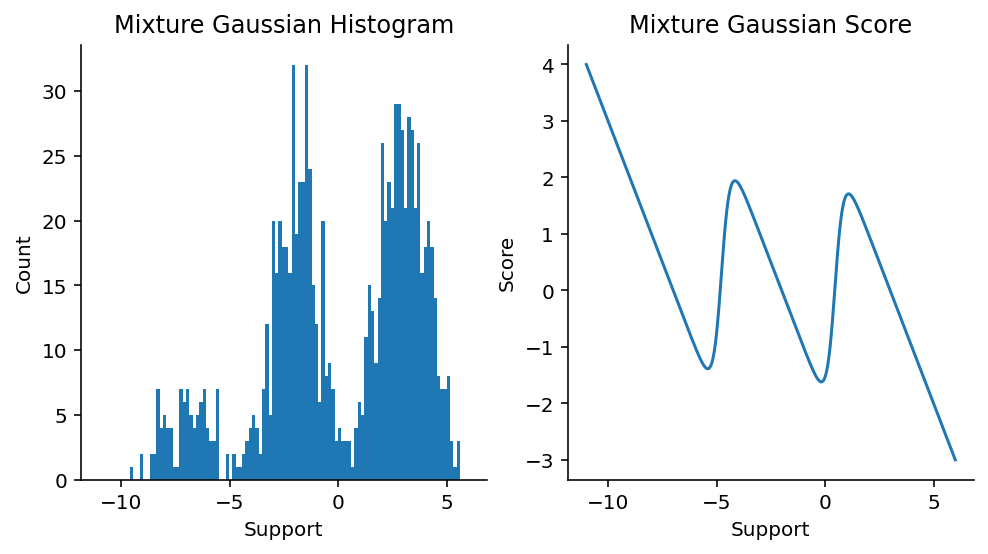

In [24]:
#| label: fig-3-comp-gaussian-mixture-score-func
#| fig-cap: 3-component mixture Gaussian score function.
#| code-fold: true

mus = np.array([-7, -2, 3])
sigmas = np.ones(3)
ws = np.array([0.1, 0.4, 0.5])


fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharex=True)
plt.sca(axes[0])
k1, k2, k3 = random.split(random.PRNGKey(91), 3)
draws = 1000
mix1 = random.normal(k1, shape=(100,)) * 1 - 7
mix2 = random.normal(k2, shape=(400,)) * 1 - 2
mix3 = random.normal(k3, shape=(500,)) * 1 + 3
data = np.concatenate([mix1, mix2, mix3]).reshape(-1, 1)
plt.hist(onp.array(data), bins=100)
plt.xlabel("Support")
plt.ylabel("Count")
plt.title("Mixture Gaussian Histogram")
sns.despine()

plt.sca(axes[1])
x = np.linspace(-11, 6, 1000)
three_comp_gaussian = MixtureGaussian(mus, np.log(sigmas), ws)

mixture_logpdf_grads = vmap(three_comp_gaussian)(x)
plt.plot(x, mixture_logpdf_grads)
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Mixture Gaussian Score")
sns.despine()

Now, let's train a 3-component Gaussian model and check its performance.
This again serves as our baseline.

In [25]:
# Sanity check that this works with a MixtureGaussianModel
three_comp_gaussian_est = MixtureGaussian(mus, np.log(sigmas), np.ones(3) / 3)
optimizer = optax.chain(
    optax.clip(0.001),
    optax.adam(learning_rate=5e-3),
)
updated_model, history = fit(
    three_comp_gaussian_est, data, losses.score_matching_loss, optimizer, steps=100, progress_bar=False
)


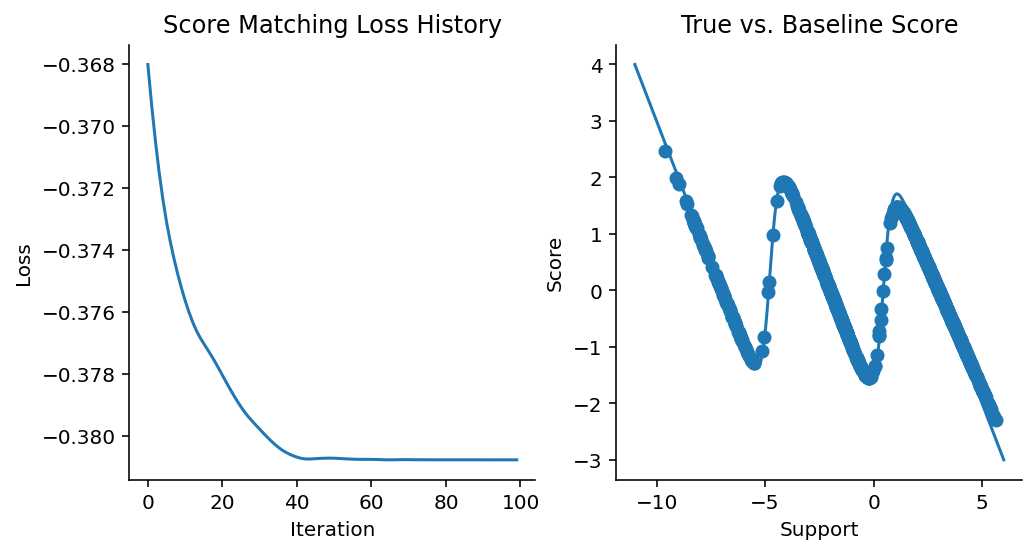

In [26]:
#| label: fig-ground-truth-3-comp-gaussian
#| fig-cap: Training performance of a 3-component Gaussian model trained on the sampled data.
#| code-fold: true

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
plt.sca(axes[0])
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Score Matching Loss History")
sns.despine()


plt.sca(axes[1])
mixture_est_scores = vmap(updated_model)(data)
plt.plot(x, mixture_logpdf_grads, label="Ground Truth")
plt.scatter(data, mixture_est_scores, label="Estimated Scores")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Baseline Score")
sns.despine()


Now, we're going to train a neural network model.

In [27]:
from functools import partial


# NOTE: I needed to tweak this neural network's
# activation function, architecture, and number of training steps quite a bit.
# Recording here the thing that trains most stably:
# - 2000 steps
# - depth = 2, width_size = 512, activation = nn.softplus
# - optax.clip(0.001), optax.adam(learning_rate = 5e-3)
# - lossses.score_matching_loss, don't do regularized.

ffmodel = FeedForwardModel1D(depth=2, width_size=512, activation=nn.softplus)
optimizer = optax.chain(
    optax.clip(0.0001),
    optax.adam(learning_rate=5e-3),
)

updated_model, history = fit(
    ffmodel,
    data,
    losses.score_matching_loss,
    optimizer,
    steps=3_000,
    progress_bar=True,
)

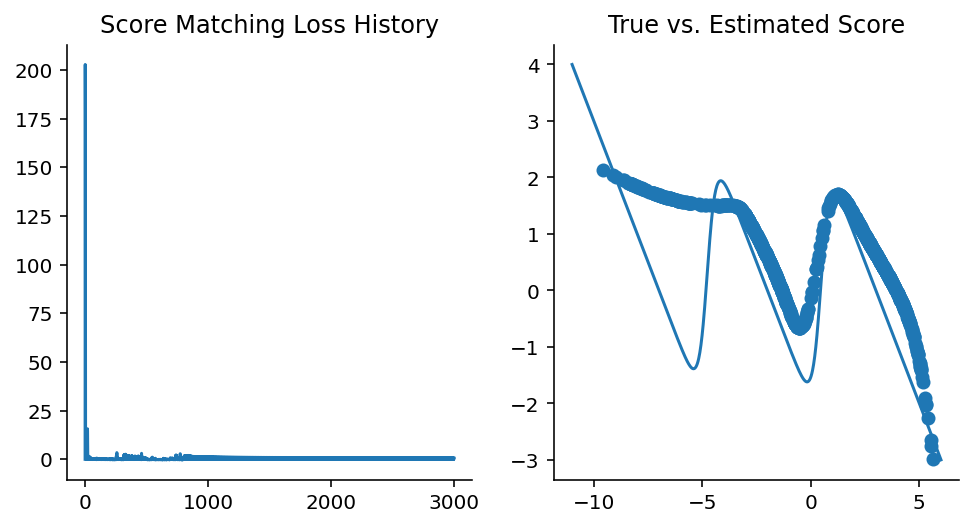

In [28]:
#| fig-cap: Training performance of feed forward neural network on 3-component Gaussian mixture.
#| label: fig-3comp-mixture-nn-performance
#| code-fold: true

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

plt.sca(axes[0])
plt.plot(history)
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
mixture_est_scores = vmap(updated_model)(data)
plt.plot(x, mixture_logpdf_grads, label="True")
plt.scatter(data, mixture_est_scores, label="Estimated")
plt.title("True vs. Estimated Score")
sns.despine()

Not bad, this actually works!
Although in this case we do know the true score function,
we are actually trying to _estimate_ it 
in the presence of draws from the data-generating distribution
while pretending to not know the true data-generating distribution.
What I've tried to show here is that 
a neural network model can approximate the true score function,
as shown in @fig-3comp-mixture-nn-performance and @fig-nn-model-mixture-loss-history.

## Up Next

Coming up next is how we _sample_ from a distribution
when knowing _only_ the score function, true or estimated.

## References